In [10]:
from os.path import join as pjoin
import numpy as np
import MAS_library as MASL
import Pk_library as PKL
import matplotlib.pyplot as plt

Load the data

In [13]:
dirname = '/data101/bartlett/ili/cmass/quijote_z0/pinocchio/L1000-N128/3/'
filename = pjoin(dirname, 'pinocchio.0.0000.pinocchio-L1000-N128-3.snapshot.out')

data = {}

with open(filename, 'rb') as f:

    # Function to read a block
    def read_block(expected_name, dtype, count):
        initial_block_size = np.fromfile(f, dtype=np.int32, count=1)[0]
        block_name = np.fromfile(f, dtype='S4', count=1)[0].decode().strip()
        block_size_with_name = np.fromfile(f, dtype=np.int32, count=1)[0]
        if block_name != expected_name:
            raise ValueError(f"Expected block name '{expected_name}', but got '{block_name}'")
        data_block = np.fromfile(f, dtype=dtype, count=count)
        trailing_block_size = np.fromfile(f, dtype=np.int32, count=1)[0]
        return data_block

    # Read the HEADER block
    header_dtype = np.dtype([
        ('dummy', np.int64),
        ('NPart', np.uint32, 6),
        ('Mass', np.float64, 6),
        ('Time', np.float64),
        ('RedShift', np.float64),
        ('flag_sfr', np.int32),
        ('flag_feedback', np.int32),
        ('NPartTotal', np.uint32, 6),
        ('flag_cooling', np.int32),
        ('num_files', np.int32),
        ('BoxSize', np.float64),
        ('Omega0', np.float64),
        ('OmegaLambda', np.float64),
        ('HubbleParam', np.float64),
        ('flag_stellarage', np.int32),
        ('flag_metals', np.int32),
        ('npartTotalHighWord', np.uint32, 6),
        ('flag_entropy_instead_u', np.int32),
        ('flag_metalcooling', np.int32),
        ('flag_stellarevolution', np.int32),
        ('fill', np.int8, 52)
    ])
    header_block = read_block('HEAD', header_dtype, 1)[0]
    data['header'] = {name: header_block[name] for name in header_dtype.names}

    # Number of particles
    num_particles = header_block['NPart'][1]

    # Read INFO block
    info_dtype = np.dtype([('name', 'S4'), ('type', 'S8'), ('ndim', np.int32), ('active', np.int32, 6)])
    d = read_block('INFO', info_dtype, 4)
    
    # Read empty FMAX block
    fmax_dtype = np.dtype([('dummy', np.int64), ('fmax', np.float32)])
    d = read_block('FMAX', fmax_dtype, 2)
    
    # Read empty RMAX block
    rmax_dtype = np.dtype([('dummy', np.int64), ('rmax', np.int64)])
    d = read_block('RMAX', rmax_dtype, 2)
    
    # Read ID block
    id_dtype = np.dtype([
        ('dummy', np.int64),
        ('ids', np.uint32, num_particles)
    ])
    ids = read_block('ID', id_dtype, 1)
    data['ids'] = ids['ids'][0]
    
    # Read POS block
    pos_dtype = np.dtype([
        ('dummy', np.int64),
        ('pos', np.float32, num_particles * 3)
    ])
    positions = read_block('POS', pos_dtype, 1)
    data['positions'] = positions['pos'].reshape(-1, 3)
    
    # Read VEL block
    vel_dtype = np.dtype([
        ('dummy', np.int64),
        ('vel', np.float32, num_particles * 3)
    ])
    positions = read_block('VEL', vel_dtype, 1)
    data['velocities'] = positions['vel'].reshape(-1, 3)
    
    print(data['ids'][:10])
    for k, v in data['header'].items():
        print(k, v)
    print(data['positions'].shape)
    print(np.amin(data['positions']), np.amax(data['positions']))  
    print(data['velocities'].shape)
    print(np.amin(data['velocities']), np.amax(data['velocities']))

[ 1  2  3  4  5  6  7  8  9 10]
dummy 1099511627784
NPart [      0 2097152       0       0       0       0]
Mass [   0.         4329.04227538    0.            0.            0.
    0.        ]
Time 1.0
RedShift 0.0
flag_sfr 0
flag_feedback 0
NPartTotal [      0 2097152       0       0       0       0]
flag_cooling 0
num_files 1
BoxSize 1000.0
Omega0 0.3271
OmegaLambda 0.6729
HubbleParam 0.6313
flag_stellarage 0
flag_metals 0
npartTotalHighWord [0 0 0 0 0 0]
flag_entropy_instead_u 0
flag_metalcooling 0
flag_stellarevolution 0
fill [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(2097152, 3)
6.471016e-05 999.99994
(2097152, 3)
-10627.973 11359.604



Using CIC mass assignment scheme
Time taken = 0.075 seconds


Computing power spectra of the fields...
Time FFTS = 0.08
Time loop = 0.06
Time taken = 0.14 seconds


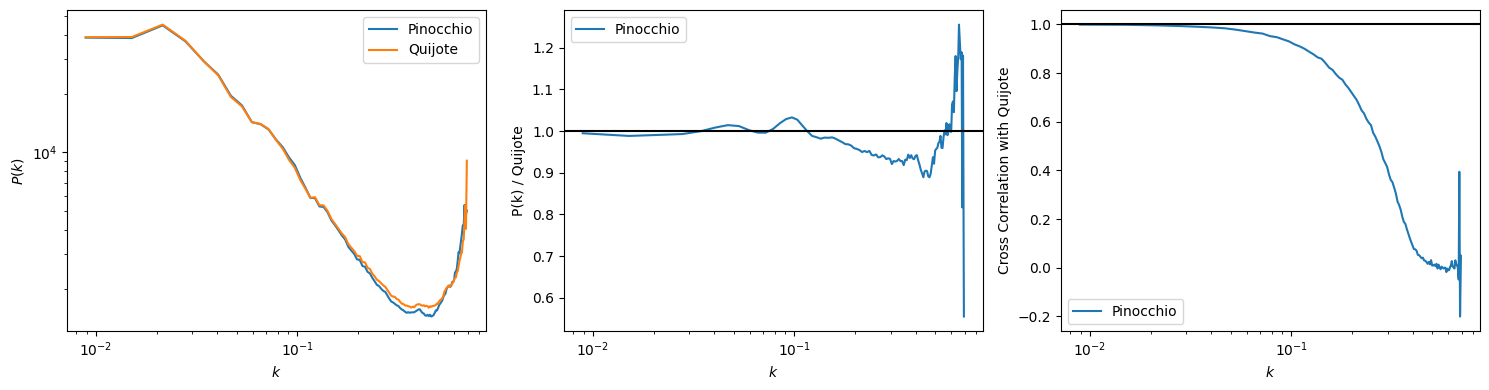

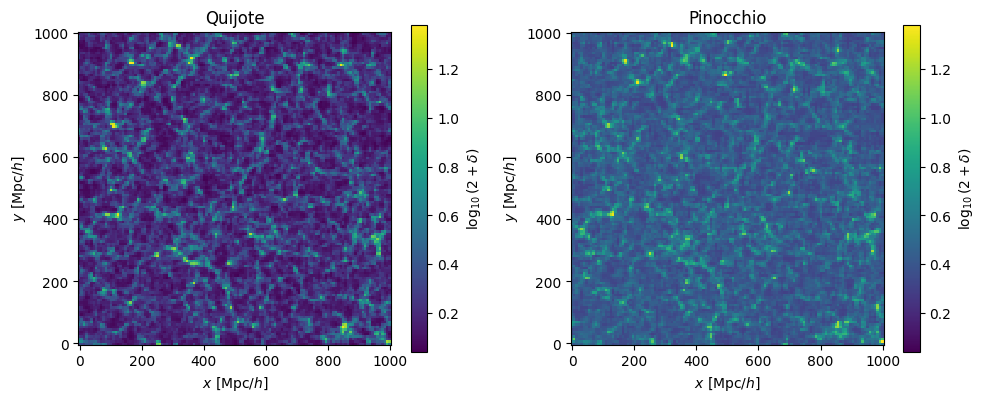

In [20]:
def compute_pk(delta, boxsize=1000, MAS='CIC'):

    Pk = PKL.Pk(delta.astype(np.float32), boxsize, axis=0, MAS=MAS, threads=1, verbose=False)
    k3D      = Pk.k3D
    Pk3D     = Pk.Pk[:,0]
    
    return k3D, Pk3D


def compute_crossk(delta1, delta2, boxsize=1000, MAS=['CIC','CIC']):
    
    Pk = PKL.XPk([delta1.astype(np.float32),delta2.astype(np.float32)], boxsize, 0, MAS=MAS, threads=1)
    
    k      = Pk.k3D
    Pk0_1  = Pk.Pk[:,0,0]  #monopole of field 1
    Pk0_2  = Pk.Pk[:,0,1]  #monopole of field 2
    Pk0_X  = Pk.XPk[:,0,0] #monopole of 1-2 cross P(k)
    
    r = Pk0_X / np.sqrt(Pk0_1 * Pk0_2)
    
    return k, Pk0_1, Pk0_2, r


N = 128
L = 1000
MAS = 'CIC'

delta_pinocchio = np.zeros((N,N,N), dtype=np.float32)
MASL.MA(data['positions'].astype(np.float32), delta_pinocchio, L, MAS, verbose=True)
delta_pinocchio = np.transpose(delta_pinocchio, (2,1,0))

delta_quijote = np.load(f'/home/mattho/data/quijote/density_field/latin_hypercube/3/df_m_{N}_z=0.npy')

k, Pk0_pinocchio, Pk0_quijote, r_pinocchio = compute_crossk(delta_pinocchio, delta_quijote)

fig, axs = plt.subplots(1, 3, figsize=(15,4))
axs[0].loglog(k, Pk0_pinocchio, label='Pinocchio')
axs[0].loglog(k, Pk0_quijote, label='Quijote')
axs[0].set_ylabel(r'$P(k)$')
axs[1].semilogx(k, Pk0_pinocchio/ Pk0_quijote, label='Pinocchio')
axs[1].axhline(1, color='k')
axs[1].set_ylabel('P(k) / Quijote')
axs[2].semilogx(k, r_pinocchio, label='Pinocchio')
axs[2].axhline(1, color='k')
axs[2].set_ylabel('Cross Correlation with Quijote')
for ax in axs:
    ax.set_xlabel(r'$k$')
    ax.legend()
fig.tight_layout()
fig.savefig('../images/pinocchio_pk.png', facecolor='white', bbox_inches='tight')

fig, axs = plt.subplots(1, 2, figsize=(10,4))

vmin = np.amin(np.log10(2 + delta_quijote[N//2]))
vmax = np.amax(np.log10(2 + delta_quijote[N//2]))
x = np.linspace(0, L, N)

pc = axs[0].pcolor(x, x, np.log10(2 + delta_quijote[N//2]), vmin=vmin, vmax=vmax)
cb = fig.colorbar(pc, ax=axs[0])
cb.set_label(r'$\log_{10}(2 + \delta)$')
axs[0].set_title('Quijote')

pc = axs[1].pcolor(x, x, np.log10(2 + delta_pinocchio[N//2]), vmin=vmin, vmax=vmax)
cb = fig.colorbar(pc, ax=axs[1])
cb.set_label(r'$\log_{10}(2 + \delta)$')
axs[1].set_title('Pinocchio')

for ax in axs:
    ax.set_aspect('equal')
    ax.set_xlabel(r'$x \ [{\rm Mpc}/h]$')
    ax.set_ylabel(r'$y \ [{\rm Mpc}/h]$')
fig.tight_layout()
fig.savefig('../images/pinocchio_field.png', facecolor='white', bbox_inches='tight')